# Анализ тарифных планов сотового оператора связи.

Компания «Мегалайн» — федеральный оператор сотовой связи, предлагает клиентам два тарифных плана: `«Смарт»` и `«Ультра»`. 
Для корректировки рекламного бюджета необходимо определить какой тариф является более прибыльным.

Будем делать предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Проанализируем  поведение клиентов и сделаем вывод — какой же тариф лучше.

**Цель исследования** — определить какой из двух тарифов более прибыльный.

**Ход исследования:**

Исследование будет проходить в несколько этапов:

- Обзор данных.
- Предобработка данных.
- Анализ данных.
- Проверка гипотезы.
- Выводы.

---------

**Описание тарифов**<br>

Тариф `«Смарт»`<br>
- Ежемесячная плата: 550 рублей
- Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика<br>
Стоимость услуг сверх тарифного пакета:
- минута разговора: 3 рубля
- сообщение: 3 рубля
- 1 Гб интернет-трафика: 200 рублей<br>

Тариф `«Ультра»`<br>
- Ежемесячная плата: 1950 рублей
- Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика<br>
Стоимость услуг сверх тарифного пакета:
- минута разговора: 1 рубль
- сообщение: 1 рубль
- 1 Гб интернет-трафика: 150 рублей
<br>

Примечание:
- «Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт.
- Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
- Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. 
Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

-----------------
**Описание данных**
<br>

Таблица **users** (информация о пользователях):
- `user_id` — уникальный идентификатор пользователя
- `first_name` — имя пользователя
- `last_name` — фамилия пользователя
- `age` — возраст пользователя (годы)
- `reg_date` — дата подключения тарифа (день, месяц, год)
- `churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- `city` — город проживания пользователя
- `tarif` — название тарифногоплана
<br>

Таблица **calls** (информация о звонках):
- `id` — уникальный номер звонка
- `call_date` — дата звонка
- `duration` — длительность звонка в минутах
- `user_id` — идентификатор пользователя, сделавшего звонок
<br>

Таблица **messages** (информация о сообщениях):
- `id` — уникальный номер сообщения
- `message_date` — дата сообщения
- `user_id` — идентификатор пользователя, отправившего сообщение
<br>

Таблица **internet** (информация об интернет-сессиях):
- `id` — уникальный номер сессии
- `mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах)
- `session_date` — дата интернет-сессии
- `user_id` — идентификатор пользователя
<br>

Таблица **tariffs** (информация о тарифах):
- `tariff_name` — название тарифа
- `rub_monthly_fee` — ежемесячная абонентская плата в рублях
- `minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату
- `messages_included` — количество сообщений в месяц, включённых в абонентскую плату
- `mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- `rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- `rub_per_message` — стоимость отправки сообщения сверх тарифного пакета
- `rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)


## Обзор данных
Для начала составим первое впечатление о данных, предоставленных для исследования. Импортируем необходимые библиотеки, читаем файлы с данными и сохраняем их в переменные. После этого выводим на экран общую информацию о таблицах, а также некоторые строки.

In [1]:
import warnings
import numpy as np
import pandas as pd
from pprint import pprint

import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import math 
from scipy import stats as st

matplotlib.style.use('ggplot')
pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None
warnings.filterwarnings(action="ignore", message="Mean of empty slice")

In [2]:
def get_info_on_dataset(_df, _full = True):
    """
    Get review on given dataset

    :param _df: pandas dataframe with data
    :param _full: True - provides full review, False - otherwise
    :return: None
    """ 
    CONST_IN_PERCENTAGES = float(100.0)
    try:
        _df.info()
        df_review_info = pd.DataFrame({'Not_Valid_Values_in %': (_df.isnull().sum()/len(_df))*CONST_IN_PERCENTAGES} )
        print("")
        print("Number of duplicated rows in the dataset: {}".format(_df.duplicated().sum()))
        print("")
        display(df_review_info.sort_values(by='Not_Valid_Values_in %', ascending=False))
    except:
        pprint("Can't provide review on given dataset")
    pass

In [3]:
df_calls = pd.read_csv('/datasets/calls.csv', sep=',')
df_internet = pd.read_csv('/datasets/internet.csv', sep=',')
df_messages = pd.read_csv('/datasets/messages.csv', sep=',')
df_tariffs = pd.read_csv('/datasets/tariffs.csv', sep=',')
df_users = pd.read_csv('/datasets/users.csv', sep=',')

# /datasets/calls.csv
# /datasets/internet.csv
# /datasets/messages.csv
# /datasets/tariffs.csv
# /datasets/users.csv

--------------------
### Dataset `Calls`

In [4]:
get_info_on_dataset(df_calls)
df_calls.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB

Number of duplicated rows in the dataset: 0



,Not_Valid_Values_in %
id,0.0
call_date,0.0
duration,0.0
user_id,0.0


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [5]:
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'], format='%Y-%m-%d')
get_info_on_dataset(df_calls)
df_calls.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  float64       
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB

Number of duplicated rows in the dataset: 0



,Not_Valid_Values_in %
id,0.0
call_date,0.0
duration,0.0
user_id,0.0


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


**Dataset Calls** - состоит из 4 столбцов, 202607 строк, пропущенных значений нет, столбец с датой звонка привели к формату Дата.

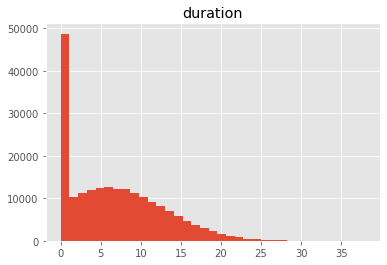

In [6]:
df_calls.hist('duration',bins=35)
plt.show()

In [7]:
df_calls['duration'].describe()

count    202607.000000
mean          6.755887
std           5.843365
min           0.000000
25%           1.300000
50%           6.000000
75%          10.700000
max          38.000000
Name: duration, dtype: float64

--------------------
### Dataset `Internet`

In [8]:
get_info_on_dataset(df_internet)
df_internet.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB

Number of duplicated rows in the dataset: 0



,Not_Valid_Values_in %
Unnamed: 0,0.0
id,0.0
mb_used,0.0
session_date,0.0
user_id,0.0


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [9]:
df_internet.drop('Unnamed: 0', inplace=True, axis=1)
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'], format='%Y-%m-%d')

In [10]:
get_info_on_dataset(df_internet)
df_internet.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            149396 non-null  object        
 1   mb_used       149396 non-null  float64       
 2   session_date  149396 non-null  datetime64[ns]
 3   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.6+ MB

Number of duplicated rows in the dataset: 0



,Not_Valid_Values_in %
id,0.0
mb_used,0.0
session_date,0.0
user_id,0.0


,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


**Dataset Internet** - состоит из 5 столбцов, 149396 строк, пропущенных значений нет, столбец с датой сессии привели к формату Дата, удалили лишний столбец `Unnamed: 0`

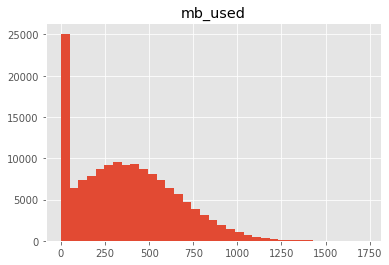

In [11]:
df_internet.hist('mb_used',bins=35)
plt.show()

In [12]:
df_internet['mb_used'].describe()

count    149396.000000
mean        370.192426
std         278.300951
min           0.000000
25%         138.187500
50%         348.015000
75%         559.552500
max        1724.830000
Name: mb_used, dtype: float64

--------------------
### Dataset `Messages`

In [13]:
get_info_on_dataset(df_messages)
df_messages.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB

Number of duplicated rows in the dataset: 0



,Not_Valid_Values_in %
id,0.0
message_date,0.0
user_id,0.0


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [14]:
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'], format='%Y-%m-%d')
get_info_on_dataset(df_messages)
df_messages.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB

Number of duplicated rows in the dataset: 0



,Not_Valid_Values_in %
id,0.0
message_date,0.0
user_id,0.0


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


**Dataset Message** - состоит из 3 столбцов, 123036 строк, пропущенных значений нет, столбец с датой отправки сообщения привели к формату Дата.

In [15]:
df_messages.groupby('message_date').count().id.describe()

count    364.000000
mean     338.010989
std      207.856660
min        4.000000
25%      147.750000
50%      335.000000
75%      521.250000
max      859.000000
Name: id, dtype: float64

In [16]:
df_messages.groupby('user_id').count().id.describe()

count     426.000000
mean      288.816901
std       267.607552
min         1.000000
25%        85.750000
50%       215.500000
75%       414.000000
max      1463.000000
Name: id, dtype: float64

--------------------
### Dataset `Tariffs`

In [17]:
get_info_on_dataset(df_tariffs)
df_tariffs.head().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes

Number of duplicated rows in the dataset: 0



,Not_Valid_Values_in %
messages_included,0.0
mb_per_month_included,0.0
minutes_included,0.0
rub_monthly_fee,0.0
rub_per_gb,0.0
rub_per_message,0.0
rub_per_minute,0.0
tariff_name,0.0


,0,1
messages_included,50,1000
mb_per_month_included,15360,30720
minutes_included,500,3000
rub_monthly_fee,550,1950
rub_per_gb,200,150
rub_per_message,3,1
rub_per_minute,3,1
tariff_name,smart,ultra


**Dataset Tariffs** - состоит из 8 столбцов, 2 строк, пропущенный значений нет.

--------------------
### Dataset `Users`

In [18]:
get_info_on_dataset(df_users)
df_users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB

Number of duplicated rows in the dataset: 0



,Not_Valid_Values_in %
churn_date,92.4
user_id,0.0
age,0.0
city,0.0
first_name,0.0
last_name,0.0
reg_date,0.0
tariff,0.0


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [19]:
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'], format='%Y-%m-%d')
df_users['churn_date'] = pd.to_datetime(df_users['churn_date'], format='%Y-%m-%d')
get_info_on_dataset(df_users)
df_users.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB

Number of duplicated rows in the dataset: 0



,Not_Valid_Values_in %
churn_date,92.4
user_id,0.0
age,0.0
city,0.0
first_name,0.0
last_name,0.0
reg_date,0.0
tariff,0.0


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [20]:
df_users.query('churn_date!= ""').head(5)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
19,1019,63,2018-10-05,Томск,Игнатий,Круглов,2018-05-16,ultra
20,1020,59,2018-12-18,Чита,Тала,Костина,2018-10-22,smart
34,1034,66,2018-11-21,Вологда,Святослав,Бондарев,2018-08-26,smart
50,1050,44,2018-10-03,Тюмень,Рузана,Аничкина,2018-06-16,ultra
51,1051,37,2018-10-14,Москва,Кристина,Сомова,2018-05-28,smart


In [21]:
df_users['city'].unique()

array(['Краснодар', 'Москва', 'Стерлитамак', 'Новокузнецк',
       'Набережные Челны', 'Ульяновск', 'Челябинск', 'Пермь', 'Тюмень',
       'Самара', 'Санкт-Петербург', 'Иваново', 'Чебоксары', 'Омск', 'Уфа',
       'Томск', 'Чита', 'Мурманск', 'Петрозаводск', 'Тверь',
       'Екатеринбург', 'Махачкала', 'Вологда', 'Череповец', 'Ярославль',
       'Сочи', 'Хабаровск', 'Ставрополь', 'Рязань', 'Улан-Удэ', 'Тула',
       'Саратов', 'Ростов-на-Дону', 'Казань', 'Иркутск', 'Курск',
       'Калуга', 'Якутск', 'Астрахань', 'Химки', 'Владикавказ',
       'Волгоград', 'Саранск', 'Ижевск', 'Новосибирск', 'Брянск',
       'Тольятти', 'Нижний Тагил', 'Орёл', 'Белгород', 'Воронеж',
       'Волжский', 'Курган', 'Барнаул', 'Красноярск', 'Архангельск',
       'Липецк', 'Кемерово', 'Киров', 'Сургут', 'Пенза', 'Магнитогорск',
       'Нижний Новгород', 'Кострома', 'Владивосток', 'Тамбов', 'Балашиха',
       'Севастополь', 'Калининград', 'Оренбург', 'Смоленск',
       'Нижневартовск', 'Владимир', 'Новороссий

In [22]:
df_users['tariff'].unique()

array(['ultra', 'smart'], dtype=object)

In [23]:
display(df_users.sort_values('age').head(2))
display(df_users.sort_values('age').tail(2))

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
77,1077,18,NaT,Москва,Марица,Кольцова,2018-10-23,smart
204,1204,18,NaT,Москва,Мирослава,Лазарева,2018-01-04,smart


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
177,1177,75,NaT,Новосибирск,Лолита,Аничкина,2018-06-19,smart
219,1219,75,NaT,Киров,Кузьма,Некрасов,2018-01-21,smart


In [24]:
display(df_users.sort_values('user_id').head(2))
display(df_users.sort_values('user_id').tail(2))

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart
499,1499,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart


**Dataset Users** - состоит из 8 столбцов, 500 строк, пропущены значения в столбце `churn_date` - оставим так, потому что при дальнейшем анализе этот столбец нам не понадобится. Столбцы `churn_date` - *дата прекращения пользования тарифом* и `reg_date`- *дата подключения тарифа* привели к формату Дата.

**Вывод:** ознакомились с данными, сделали предвательную чистку, проверку на дубликаты и пропуски, изучили уникальные значения. Далее приступаем к подготовке данных для анализа.

## Подготовка данных

--------------------
### Dataset `Internet`

Определим ежемесячный объём израсходованного Интернет-трафика для каждого "user_id"

In [25]:
df_internet['month'] = df_internet['session_date'].dt.month
df_internet['year'] = df_internet['session_date'].dt.year
df_internet['year'].unique()

array([2018])

In [26]:
df_internet_stats = df_internet.groupby(\
                                  ['user_id','month'])\
                                  ['mb_used'].agg(['sum']).reset_index()
df_internet_stats = df_internet_stats.rename(columns={'sum': 'sum_month_mb'})
df_internet_stats.head(10)


,user_id,month,sum_month_mb
0,1000,5,2253.49
1,1000,6,23233.77
2,1000,7,14003.64
3,1000,8,14055.93
4,1000,9,14568.91
5,1000,10,14702.49
6,1000,11,14756.47
7,1000,12,9817.61
8,1001,11,18429.34
9,1001,12,14036.66


In [27]:
df_internet_stats['gb_used'] = (df_internet_stats['sum_month_mb']/1024).apply(np.ceil)
df_internet_stats.head()

,user_id,month,sum_month_mb,gb_used
0,1000,5,2253.49,3.0
1,1000,6,23233.77,23.0
2,1000,7,14003.64,14.0
3,1000,8,14055.93,14.0
4,1000,9,14568.91,15.0


В Dataset `Internet` добавили столбцы `month`, `year`. Проверили, что в данных только 2018 год. Сгруппировали таблицу по `user_id` и `month`, нашли сумму Мб в месяц и округлили до Гб -  столбец `gb_used`.

--------------------
### Dataset `Сalls`

Определим ежемесячное количество звонков и минут разговора для каждого "user_id"

In [28]:
df_calls['month'] = df_calls['call_date'].dt.month
df_calls['year'] = df_calls['call_date'].dt.year
df_calls['year'].unique()

array([2018])

In [29]:
df_calls['duration_ceil']=df_calls['duration'].apply(np.ceil)
df_calls.head()

,id,call_date,duration,user_id,month,year,duration_ceil
0,1000_0,2018-07-25,0.00,1000,7,2018,0.0
1,1000_1,2018-08-17,0.00,1000,8,2018,0.0
2,1000_2,2018-06-11,2.85,1000,6,2018,3.0
3,1000_3,2018-09-21,13.80,1000,9,2018,14.0
4,1000_4,2018-12-15,5.18,1000,12,2018,6.0


In [30]:
df_calls_stats = pd.pivot_table(df_calls,
                                 index=['user_id','month'],
                                 values='duration_ceil', aggfunc=['count','sum']).reset_index()
df_calls_stats.columns = ['user_id','month','calls_number','calls_duration']
df_calls_stats.head()

,user_id,month,calls_number,calls_duration
0,1000,5,22,159.0
1,1000,6,43,172.0
2,1000,7,47,340.0
3,1000,8,52,408.0
4,1000,9,58,466.0


В Dataset `Calls` добавили столбцы `month`, `year`. Проверили, что в данных только 2018 год. Создали сводную таблицу по столбцам  `user_id` и `month`, нашли количество и общую продолжительность звонков за месяц.

--------------------
### Dataset `Messages`

Определим ежемесячное количество отправленных сообщений для каждого "user_id"

In [31]:
df_messages['month'] = df_messages['message_date'].dt.month
df_messages['year'] = df_messages['message_date'].dt.year
df_messages['year'].unique()

array([2018])

In [32]:
df_messages_stats = pd.pivot_table(df_messages,
                                 index=['user_id','month'],
                                 values='message_date', aggfunc='count').reset_index()

df_messages_stats = df_messages_stats.rename(columns={'message_date': 'messages_number'})
df_messages_stats.head(10)

,user_id,month,messages_number
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
5,1000,10,73
6,1000,11,58
7,1000,12,70
8,1002,6,4
9,1002,7,11


In [33]:
df_messages.query('user_id == 1002 and month == 6')

,id,message_date,user_id,month,year
505,1002_9,2018-06-17,1002,6,2018
524,1002_28,2018-06-23,1002,6,2018
535,1002_39,2018-06-19,1002,6,2018
546,1002_50,2018-06-23,1002,6,2018


В Dataset `Messages` добавили столбцы `month`, `year`. Проверили, что в данных только 2018 год. Создали сводную таблицу по столбцам  `user_id` и `month`, нашли количество сообщений в месяц.

--------------------
### Итоговая сводная таблица

Сводим таблицы в одну по первичным ключам `user_id & month` и `user_id`

In [34]:
print("Количество строк df_users          ", df_users.shape[0])
print("Количество строк df_internet_stats ", df_internet_stats.shape[0])
print("Количество строк df_calls_stats    ", df_calls_stats.shape[0])
print("Количество строк df_messages_stats ", df_messages_stats.shape[0])
print("Количество строк df_tariffs        ", df_tariffs.shape[0])

Количество строк df_users           500
Количество строк df_internet_stats  3203
Количество строк df_calls_stats     3174
Количество строк df_messages_stats  2717
Количество строк df_tariffs         2


In [35]:
resulting_df = df_users.merge(df_calls_stats, on=['user_id'], how='outer')
print("Количество строк resulting_df ", resulting_df.shape[0])
resulting_df.head(3)

Количество строк resulting_df  3182


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,calls_number,calls_duration
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5.0,22.0,159.0
1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6.0,43.0,172.0
2,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7.0,47.0,340.0


In [36]:
resulting_df = resulting_df.merge(df_messages_stats, on=['user_id', 'month'], how='outer')
print("Количество строк resulting_df ", resulting_df.shape[0])
resulting_df.head(3)

Количество строк resulting_df  3221


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,calls_number,calls_duration,messages_number
0,1000,52.0,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5.0,22.0,159.0,22.0
1,1000,52.0,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6.0,43.0,172.0,60.0
2,1000,52.0,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7.0,47.0,340.0,75.0


In [37]:
resulting_df = resulting_df.merge(df_internet_stats, on=['user_id', 'month'], how='outer')
print("Количество строк resulting_df ", resulting_df.shape[0])
resulting_df.head(3)

Количество строк resulting_df  3222


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,calls_number,calls_duration,messages_number,sum_month_mb,gb_used
0,1000,52.0,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5.0,22.0,159.0,22.0,2253.49,3.0
1,1000,52.0,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6.0,43.0,172.0,60.0,23233.77,23.0
2,1000,52.0,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7.0,47.0,340.0,75.0,14003.64,14.0


In [38]:
df_tariffs = df_tariffs.rename(columns={'tariff_name': 'tariff'})
resulting_df = resulting_df.merge(df_tariffs, on=['tariff'], how='outer')
print("Количество строк resulting_df ", resulting_df.shape[0])
resulting_df.sample(5).T

Количество строк resulting_df  3222


,622,1033,3130,2210,2024
user_id,1350,1012,1487,1274,1228
age,40.0,38.0,72.0,53.0,28.0
churn_date,NaT,NaT,NaT,NaT,NaT
city,Омск,Санкт-Петербург,Кострома,Волгоград,Нижний Новгород
first_name,Варвара,Варлам,Рудольф,Аксён,Денис
last_name,Козырева,Соловьев,Кириллов,Еремин,Алфимов
reg_date,2018-08-30 00:00:00,2018-03-28 00:00:00,2018-08-13 00:00:00,2018-05-03 00:00:00,2018-04-17 00:00:00
tariff,ultra,smart,smart,smart,smart
month,12.0,12.0,8.0,12.0,7.0
calls_number,52.0,43.0,11.0,56.0,78.0


In [39]:
resulting_df[['calls_number', 'calls_duration', 'messages_number', 'gb_used']].describe()

,calls_number,calls_duration,messages_number,gb_used
count,3174.000000,3174.000000,2717.000000,3203.000000
mean,63.833333,456.931632,45.283769,17.358414
std,32.678036,238.031270,35.051363,7.343379
min,1.000000,0.000000,1.000000,0.000000
25%,41.000000,290.000000,19.000000,13.000000
50%,63.000000,447.000000,38.000000,17.000000
75%,83.000000,592.000000,63.000000,21.000000
max,244.000000,1673.000000,224.000000,49.000000


In [40]:
df_calls_stats.drop(['user_id', 'month'], axis=1).describe().\
join(df_messages_stats.drop(['user_id', 'month'], axis=1).describe()).\
join(df_internet_stats.drop(['user_id', 'month','sum_month_mb'], axis=1).describe())

,calls_number,calls_duration,messages_number,gb_used
count,3174.000000,3174.000000,2717.000000,3203.000000
mean,63.833333,456.931632,45.283769,17.358414
std,32.678036,238.031270,35.051363,7.343379
min,1.000000,0.000000,1.000000,0.000000
25%,41.000000,290.000000,19.000000,13.000000
50%,63.000000,447.000000,38.000000,17.000000
75%,83.000000,592.000000,63.000000,21.000000
max,244.000000,1673.000000,224.000000,49.000000


In [41]:
resulting_df.drop(['age','first_name','last_name','sum_month_mb','churn_date','reg_date'], inplace=True, axis=1)
resulting_df.sample(5).T

,1771,454,1004,1595,1639
user_id,1176,1272,1009,1141,1149
city,Волгоград,Пенза,Пермь,Москва,Мурманск
tariff,smart,ultra,smart,smart,smart
month,2.0,12.0,8.0,12.0,6.0
calls_number,57.0,42.0,33.0,36.0,24.0
calls_duration,325.0,343.0,249.0,211.0,159.0
messages_number,27.0,61.0,9.0,1.0,91.0
gb_used,14.0,24.0,24.0,15.0,23.0
messages_included,50.0,1000.0,50.0,50.0,50.0
mb_per_month_included,15360.0,30720.0,15360.0,15360.0,15360.0


In [42]:
get_info_on_dataset(resulting_df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3222 entries, 0 to 3221
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                3222 non-null   int64  
 1   city                   3182 non-null   object 
 2   tariff                 3182 non-null   object 
 3   month                  3214 non-null   float64
 4   calls_number           3174 non-null   float64
 5   calls_duration         3174 non-null   float64
 6   messages_number        2717 non-null   float64
 7   gb_used                3203 non-null   float64
 8   messages_included      3182 non-null   float64
 9   mb_per_month_included  3182 non-null   float64
 10  minutes_included       3182 non-null   float64
 11  rub_monthly_fee        3182 non-null   float64
 12  rub_per_gb             3182 non-null   float64
 13  rub_per_message        3182 non-null   float64
 14  rub_per_minute         3182 non-null   float64
dtypes: f

,Not_Valid_Values_in %
messages_number,15.673495
calls_number,1.489758
calls_duration,1.489758
city,1.241465
tariff,1.241465
messages_included,1.241465
mb_per_month_included,1.241465
minutes_included,1.241465
rub_monthly_fee,1.241465
rub_per_gb,1.241465


In [43]:
resulting_df.query('month != month').T

,151,197,228,380,554,929,2590,3137
user_id,1091,1106,1128,1231,1328,1473,1371,1489
city,Набережные Челны,Калуга,Волжский,Чебоксары,Мурманск,Красноярск,Омск,Санкт-Петербург
tariff,ultra,ultra,ultra,ultra,ultra,ultra,smart,smart
month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
calls_number,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
calls_duration,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
messages_number,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gb_used,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
messages_included,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,50.0,50.0
mb_per_month_included,30720.0,30720.0,30720.0,30720.0,30720.0,30720.0,15360.0,15360.0


In [44]:
resulting_df.query('messages_number != messages_number').head(3).T

,49,50,51
user_id,1024,1024,1024
city,Санкт-Петербург,Санкт-Петербург,Санкт-Петербург
tariff,ultra,ultra,ultra
month,10.0,11.0,12.0
calls_number,7.0,157.0,136.0
calls_duration,79.0,1146.0,949.0
messages_number,NaN,NaN,NaN
gb_used,4.0,43.0,36.0
messages_included,1000.0,1000.0,1000.0
mb_per_month_included,30720.0,30720.0,30720.0


In [45]:
resulting_df.query('gb_used  != gb_used').head(3).T

,151,197,228
user_id,1091,1106,1128
city,Набережные Челны,Калуга,Волжский
tariff,ultra,ultra,ultra
month,NaN,NaN,NaN
calls_number,NaN,NaN,NaN
calls_duration,NaN,NaN,NaN
messages_number,NaN,NaN,NaN
gb_used,NaN,NaN,NaN
messages_included,1000.0,1000.0,1000.0
mb_per_month_included,30720.0,30720.0,30720.0


In [46]:
resulting_df.dropna(subset = ['month'], inplace = True)
resulting_df.reset_index(drop=True, inplace=True)
resulting_df.fillna(0, inplace=True)
resulting_df['month'] = resulting_df['month'].astype('int64')
resulting_df['calls_number'] = resulting_df['calls_number'].astype('int64')
resulting_df['calls_duration'] = resulting_df['calls_duration'].astype('int64')
resulting_df['messages_number'] = resulting_df['messages_number'].astype('int64')
resulting_df['gb_used'] = resulting_df['gb_used'].astype('int64')
get_info_on_dataset(resulting_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                3214 non-null   int64  
 1   city                   3214 non-null   object 
 2   tariff                 3214 non-null   object 
 3   month                  3214 non-null   int64  
 4   calls_number           3214 non-null   int64  
 5   calls_duration         3214 non-null   int64  
 6   messages_number        3214 non-null   int64  
 7   gb_used                3214 non-null   int64  
 8   messages_included      3214 non-null   float64
 9   mb_per_month_included  3214 non-null   float64
 10  minutes_included       3214 non-null   float64
 11  rub_monthly_fee        3214 non-null   float64
 12  rub_per_gb             3214 non-null   float64
 13  rub_per_message        3214 non-null   float64
 14  rub_per_minute         3214 non-null   float64
dtypes: f

,Not_Valid_Values_in %
user_id,0.0
city,0.0
tariff,0.0
month,0.0
calls_number,0.0
calls_duration,0.0
messages_number,0.0
gb_used,0.0
messages_included,0.0
mb_per_month_included,0.0


In [47]:
resulting_df.head().T

,0,1,2,3,4
user_id,1000,1000,1000,1000,1000
city,Краснодар,Краснодар,Краснодар,Краснодар,Краснодар
tariff,ultra,ultra,ultra,ultra,ultra
month,5,6,7,8,9
calls_number,22,43,47,52,58
calls_duration,159,172,340,408,466
messages_number,22,60,75,81,57
gb_used,3,23,14,14,15
messages_included,1000.0,1000.0,1000.0,1000.0,1000.0
mb_per_month_included,30720.0,30720.0,30720.0,30720.0,30720.0


Привели данные к нужным типам, заполнили пропуски и сгруппировали данные в 1 таблицу `resulting_df`

In [48]:
resulting_df_test = df_calls_stats.merge(df_messages_stats, on=['user_id', 'month'], how='outer').merge(df_internet_stats, on=['user_id', 'month'], how='outer').merge(df_users, on=['user_id'])
resulting_df_test = resulting_df_test.merge(df_tariffs, on=['tariff'], how='outer')
print("Количество строк resulting_df_test ", resulting_df_test.shape[0])
resulting_df_test[['calls_number', 'calls_duration', 'messages_number', 'gb_used']].describe()

Количество строк resulting_df_test  3214


,calls_number,calls_duration,messages_number,gb_used
count,3174.000000,3174.000000,2717.000000,3203.000000
mean,63.833333,456.931632,45.283769,17.358414
std,32.678036,238.031270,35.051363,7.343379
min,1.000000,0.000000,1.000000,0.000000
25%,41.000000,290.000000,19.000000,13.000000
50%,63.000000,447.000000,38.000000,17.000000
75%,83.000000,592.000000,63.000000,21.000000
max,244.000000,1673.000000,224.000000,49.000000


In [49]:
df_calls_stats.drop(['user_id', 'month'], axis=1).describe().\
join(df_messages_stats.drop(['user_id', 'month'], axis=1).describe()).\
join(df_internet_stats.drop(['user_id', 'month','sum_month_mb'], axis=1).describe())

,calls_number,calls_duration,messages_number,gb_used
count,3174.000000,3174.000000,2717.000000,3203.000000
mean,63.833333,456.931632,45.283769,17.358414
std,32.678036,238.031270,35.051363,7.343379
min,1.000000,0.000000,1.000000,0.000000
25%,41.000000,290.000000,19.000000,13.000000
50%,63.000000,447.000000,38.000000,17.000000
75%,83.000000,592.000000,63.000000,21.000000
max,244.000000,1673.000000,224.000000,49.000000


In [50]:
resulting_df_test.query('month != month').T

""
user_id
month
calls_number
calls_duration
messages_number
sum_month_mb
gb_used
age
churn_date
city


**Определим ежемесячную выручку компании, полученную от каждого `user_id`**

In [51]:
def user_id_revenue(_row):
    
    user_revenue_amount = _row['rub_monthly_fee']

    if _row['calls_duration'] > _row['minutes_included']:
        user_revenue_amount += (_row['calls_duration'] - _row['minutes_included'])*_row['rub_per_minute'] 
    
    if _row['messages_number'] > _row['messages_included']:
        user_revenue_amount += (_row['messages_number'] - _row['messages_included'])*_row['rub_per_message']  

    if _row['gb_used'] > _row['mb_per_month_included']/1024:
        user_revenue_amount += ((_row['gb_used'] - _row['mb_per_month_included']/1024)*_row['rub_per_gb'] ) 
        
    return round(user_revenue_amount, 2)

In [52]:
resulting_df['user_revenue'] = resulting_df.apply(user_id_revenue, axis=1)

In [53]:
resulting_df.sample(10).T

,1003,2704,1627,938,1333,1253,886,2028,932,1498
user_id,1010,1395,1147,1491,1079,1064,1458,1230,1476,1119
city,Тюмень,Москва,Якутск,Челябинск,Москва,Якутск,Барнаул,Томск,Москва,Петрозаводск
tariff,smart,smart,smart,ultra,smart,smart,ultra,smart,ultra,smart
month,8,11,8,7,7,11,9,10,11,7
calls_number,19,91,33,80,74,68,115,56,71,34
calls_duration,142,637,243,606,592,479,856,447,556,277
messages_number,0,26,36,58,30,40,3,17,6,44
gb_used,15,19,20,21,11,15,19,20,15,20
messages_included,50.0,50.0,50.0,1000.0,50.0,50.0,1000.0,50.0,1000.0,50.0
mb_per_month_included,15360.0,15360.0,15360.0,30720.0,15360.0,15360.0,30720.0,15360.0,30720.0,15360.0


Создали фукнцию для расчета помесячной выручки от каждого пользователя, с ее помощью расчитали выручку и добавили столбцом `user_revenue` в итоговую таблицу `resulting_df`.

## Анализ данных


In [54]:
def plot_hists(_df, 
               _c_t,
               _func = 'mean',
               _bins = 50, 
               _x_ticks_range = [],
               _y_ticks_range = [],
               _width = 20, 
               _height = 12, 
               _fontsize=15):
    """ 
    Plot histograms
    :param _df : pandas dataframe with data
    :param _c_t : column title 
    :param _bins: bins number  
    :param _width: width value
    :param _height: height value
    :param _fontsize: fontsize value
    :return: None 
    """   
    try:
        
        plt.figure(figsize=(_width, _height))

        sns.histplot(data=resulting_df.query('tariff == "smart"'), 
                     x=_c_t, 
                     color="crimson", 
                     label= _c_t + ' [ "smart" ]', 
                     bins = _bins, 
                     kde=True)
        
        sns.histplot(data=resulting_df.query('tariff == "ultra"'), 
                     x=_c_t, 
                     color="c", 
                     label=_c_t + ' [ "ultra" ]', 
                     bins = _bins, 
                     kde=True)

        plt.xlabel(_c_t, fontsize=_fontsize)
        plt.ylabel('', fontsize=_fontsize)
        plt.yticks(fontsize=_fontsize)
        plt.xticks(fontsize=_fontsize)
        
        if _x_ticks_range:
            plt.xlim(*_x_ticks_range) 
        if _y_ticks_range:
            plt.ylim(*_y_ticks_range)


        mm_smart_value = eval("_df.loc[_df['tariff'] == 'smart', '{}'].".format(_c_t) + _func + "()")      
        mm_ultra_value = eval("_df.loc[_df['tariff'] == 'ultra', '{}'].".format(_c_t) + _func + "()")
        
        plt.axvline(x=mm_smart_value, color='black', lw = 5, ls = ':', label = "smart " \
                    + _func + " value: {}".format(round(mm_smart_value,2)))
        plt.axvline(x=mm_ultra_value, color='blue', lw = 5, ls = ':', label = "ultra " \
                    + _func + " value: {}".format(round(mm_ultra_value,2)))
            
        plt.legend(fontsize = '15', title_fontsize = "10")
        plt.show() 

        
    except:
        pprint("Can't provide boxplot plotting")
        
    pass


def plot_catplot(_df_data, 
                 _x_col_title,
                 _y_col_title,
                 _x_ticks_range = [],
                 _y_ticks_range = [],
                 _x_axis_label = "", 
                 _y_axis_label = "", 
                 _height= 1, 
                 _aspect = 1, 
                 _order = [],
                 _fontsize=12):
    """ 
    Plot catplot
    :param _df_data: pandas dataframe series with x data
    :param _x_axis_label: x-axis label
    :param _y_axis_label: y-axis label    
    :param _width: width value
    :param _height: height value
    :param _fontsize: fontsize value
    :return: None 
    """   

    try:
        
        #plt.figure(figsize=(_width, _height))
                    
        if _order:
            sns.catplot(x=_x_col_title, y=_y_col_title, kind="box", data=_df_data, \
                        height=_height, aspect=_aspect, palette='dark', order=_order)
        else:
            sns.catplot(x=_x_col_title, y=_y_col_title, kind="box", data=_df_data, \
                        height=_height, aspect=_aspect, palette='dark')
            
        #plt.xlabel(_x_axis_label, fontsize=_fontsize)
        #plt.ylabel(_y_axis_label, fontsize=_fontsize)
        
        if _x_ticks_range:
            plt.xlim(*_x_ticks_range) 
        if _y_ticks_range:
            plt.ylim(*_y_ticks_range)

    except:
        pprint("Can't provide catplot plotting")
        
    pass

def get_box_and_whisker_info(_x_data):
    """ 
    Get info on box_and_whisker
    :param _x_data: pandas dataframe series with x data
    :return: None 
    """       
    Q1_QUANTILE_VALUE_CONST = float(0.25)
    Q3_QUANTILE_VALUE_CONST = float(0.75)
    IQR_MULT_DEFAULT_CONST = float(1.5)
    
    try:
        Q1 = _x_data.quantile(Q1_QUANTILE_VALUE_CONST)
        Q3 = _x_data.quantile(Q3_QUANTILE_VALUE_CONST)
        IQR = Q3 - Q1 
            
        outliers_low_bound = Q1 - IQR_MULT_DEFAULT_CONST*IQR
        outliers_upper_bound = Q3 + IQR_MULT_DEFAULT_CONST*IQR      

        pprint("Q1 == {:.2f}, Q3 == {:.2f}, IQR == {:.2f}".format(Q1, Q3, IQR))
        pprint("[Q1 - 1.5*IQR] == {:.2f}, [Q3 + 1.5*IQR] == {:.2f}".format(outliers_low_bound, outliers_upper_bound))
        
    except:
        pprint("Can't provide box_and_whisker related info on given data")
        
    pass

----------------
### Количество минут пользователей тарифов
Среднее, медиана, дисперсия и стандартное отклонение для количества минут пользователей двух тарифов


In [55]:
user_id_resulting_df = resulting_df.pivot_table(index=['tariff'],
                                             values=['user_id'], 
                                             aggfunc=['count']).reset_index().round()
user_id_resulting_df.columns = ['tariff', 'count_user_id']

user_tariff_resulting_df = resulting_df.pivot_table(index=['tariff'],
                                             values=['calls_duration','calls_number','gb_used','messages_number','user_revenue'], 
                                             aggfunc=['sum']).reset_index().round()
user_tariff_resulting_df.columns = ['tariff', 'sum_calls_duration','sum_calls_number','sum_gb_used','sum_messages_number','user_revenue']

user_id_tariff_resulting_df = user_id_resulting_df.merge(user_tariff_resulting_df, on=['tariff'], how='left')
user_id_tariff_resulting_df

,tariff,count_user_id,sum_calls_duration,sum_calls_number,sum_gb_used,sum_messages_number,user_revenue
0,0,40,0,0,765,2165,0.0
1,smart,2223,931577,130315,36301,74240,2869651.0
2,ultra,951,518724,72292,18533,46631,1969500.0


In [56]:
calls_resulting_df = resulting_df.pivot_table(index=['tariff'],
                           values='calls_duration',
                           aggfunc=['median','mean', np.std, np.var, 'sum']).reset_index().round()

calls_resulting_df.columns = ['tariff', 'calls_median', 'calls_mean', 'calls_std', 'calls_var', 'calls_sum_duration']
calls_resulting_df

,tariff,calls_median,calls_mean,calls_std,calls_var,calls_sum_duration
0,0,0,0.0,0.0,0.0,0
1,smart,423,419.0,189.0,35844.0,931577
2,ultra,528,545.0,307.0,94203.0,518724


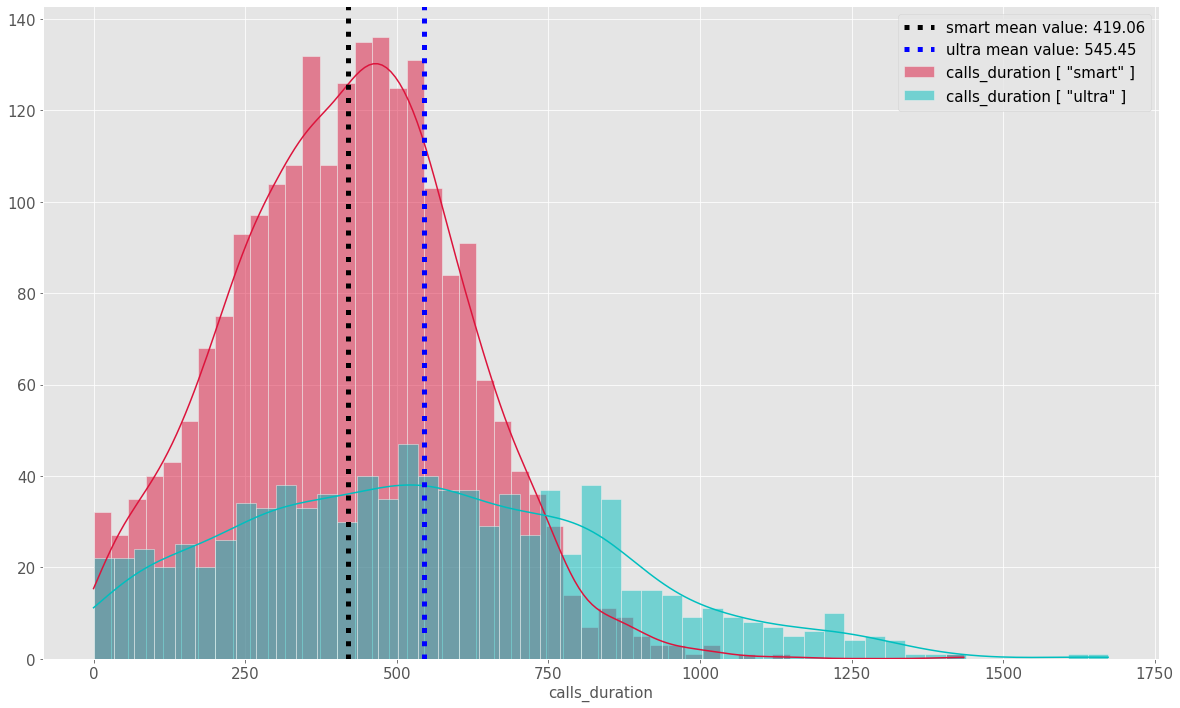

In [57]:
plot_hists(resulting_df, _c_t = "calls_duration", _func = "mean")

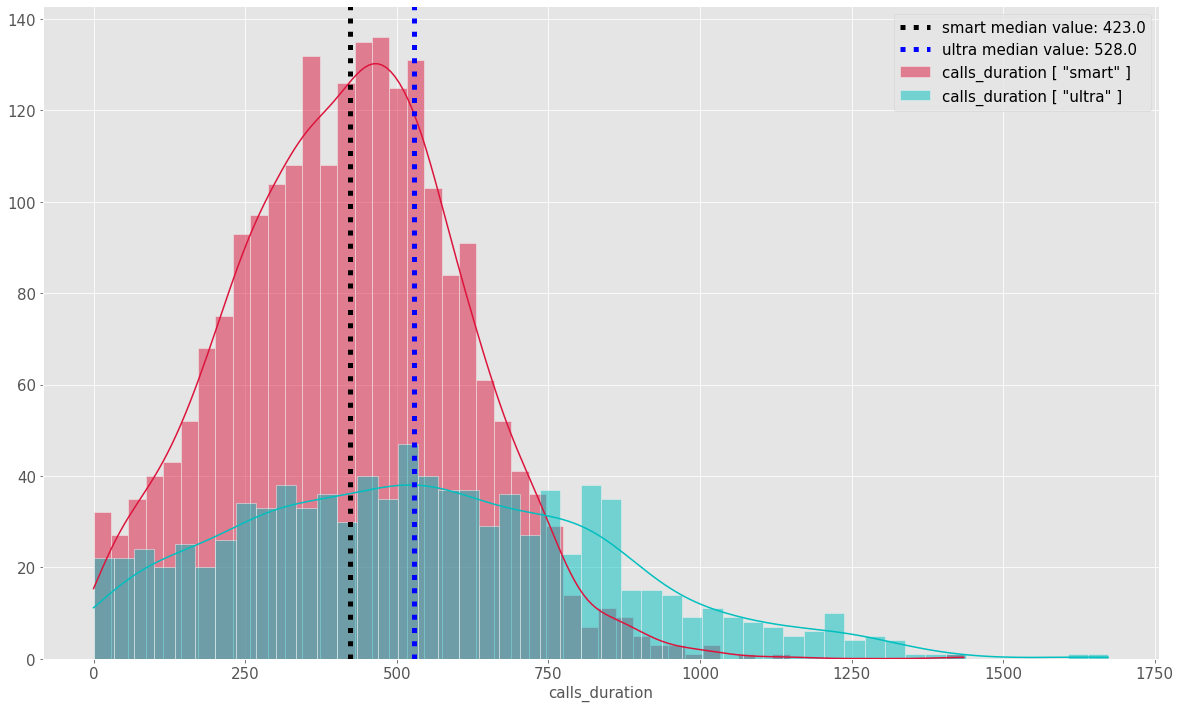

In [58]:
plot_hists(resulting_df, _c_t = "calls_duration", _func = "median")

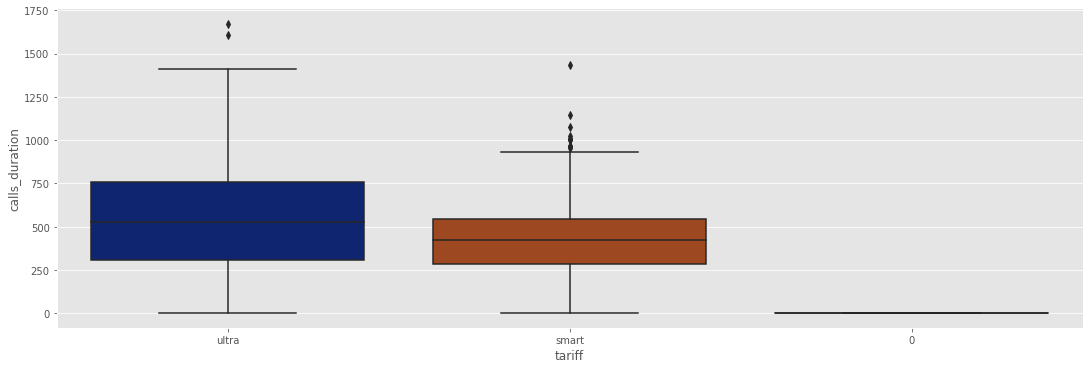

In [59]:
plot_catplot(resulting_df, 'tariff', 'calls_duration', _height = 5, _aspect = 3)

In [60]:
print("Включено минут в тарифы 'smart' и 'ultra' ")
display(df_tariffs[['tariff', 'minutes_included']])
print("")
print("Фактически минут тарифа 'smart'")
get_box_and_whisker_info(resulting_df.query('tariff == "smart"')['calls_duration'])
print("")
print("Фактически минут тарифа 'ultra'")
get_box_and_whisker_info(resulting_df.query('tariff == "ultra"')['calls_duration'])

Включено минут в тарифы 'smart' и 'ultra' 


,tariff,minutes_included
0,smart,500
1,ultra,3000



Фактически минут тарифа 'smart'
'Q1 == 285.00, Q3 == 545.50, IQR == 260.50'
'[Q1 - 1.5*IQR] == -105.75, [Q3 + 1.5*IQR] == 936.25'

Фактически минут тарифа 'ultra'
'Q1 == 310.00, Q3 == 756.50, IQR == 446.50'
'[Q1 - 1.5*IQR] == -359.75, [Q3 + 1.5*IQR] == 1426.25'


В нашей выборке абонентов подключенных к тарифу `smart` 70% (2223 пользователя), а абонентов тарифа `ultra` 30% (951 пользователь).<br>

Тариф `smart` <br>
Пользователи тарифа `smart` используют в основном от 280 до 550 минут в месяц, ~ 25% пользователей выходят за рамки минут включенных в абонентскую плату тарифа (500 минут/месяц).<br>
Распределение гистограммы близко к нормальному, большая часть значений лежит в промежутке от 280 до 550 минут, значения средней и медианы находится близко друг от друга.<br>
Типичный представитель данного тарифа разговаривает около 420 минут/месяц.

Тариф `ultra` <br>
Пользователи тарифа `ultra` используют в основном от 300 до 760 минут в месяц, но никто из пользователей не превышает лимит минут включенный в абонентскую плату тарифа (3000 минут/месяц).<br>
Гистограмма скошена вправо. Значение медианы немного меньше среднего. На гистограмме видно, что есть ряд высоких значений, которые не влияют на медиану, но влияют на среднее.<br>
Типичный представитель тарифа `ultra` разговаривает около 550 минут/месяц.

В целом пользователи тарифа `smart` разговаривают меньше, чем пользователи `ultra`. 
По гистограмме хорошо видно, что в тарифе `ultra` пользователей использующих более 500 минут в месяц гораздо больше, чем в тарифе `smart`. Но при этом никто из абонентов тарифа `ultra` не выходит за рамки включенных в данных тариф минут.


----------------
### Количество сообщений пользователей тарифов
Среднее, медиана, дисперсия и стандартное отклонение для количества сообщений пользователей двух тарифов

In [61]:
massage_resulting_df = resulting_df.pivot_table(index=['tariff'],
                           values='messages_number',
                           aggfunc=['median','mean', np.std, np.var]).reset_index().round()

massage_resulting_df.columns = ['tariff','message_median', 'message_mean', 'message_std', 'message_var']
massage_resulting_df

,tariff,message_median,message_mean,message_std,message_var
0,0,30.0,54.0,64.0,4157.0
1,smart,28.0,33.0,28.0,799.0
2,ultra,39.0,49.0,47.0,2199.0


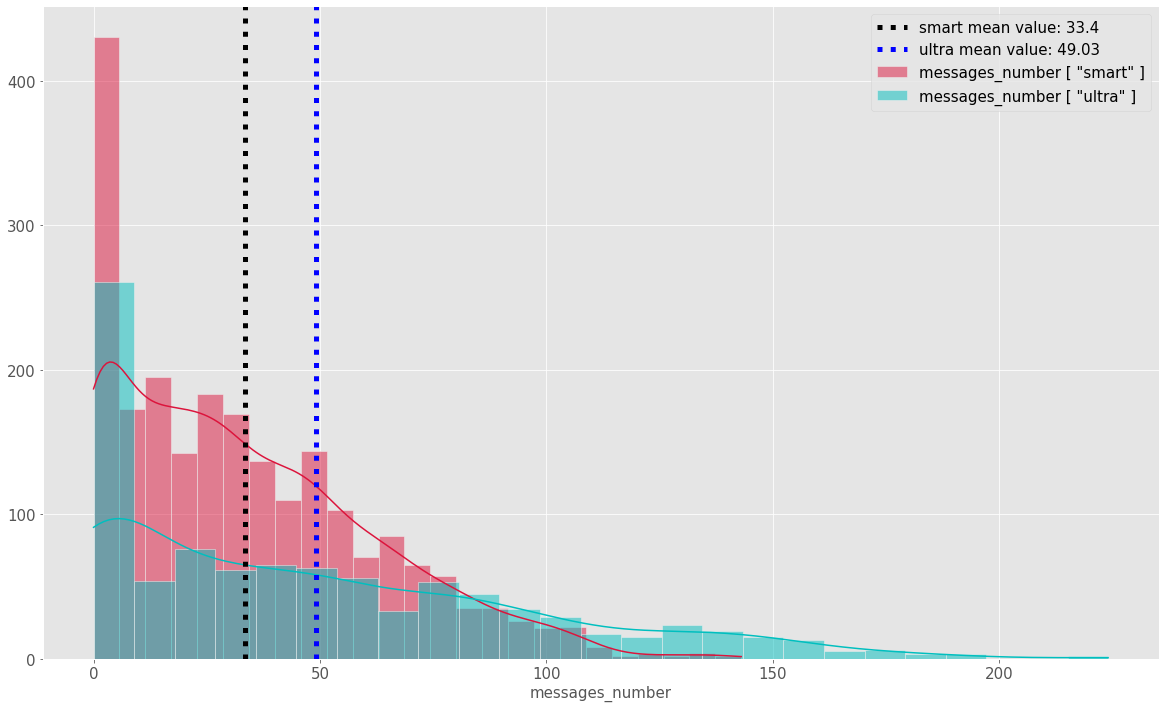

In [62]:
plot_hists(resulting_df, _c_t = 'messages_number', _func = 'mean', _bins=25)

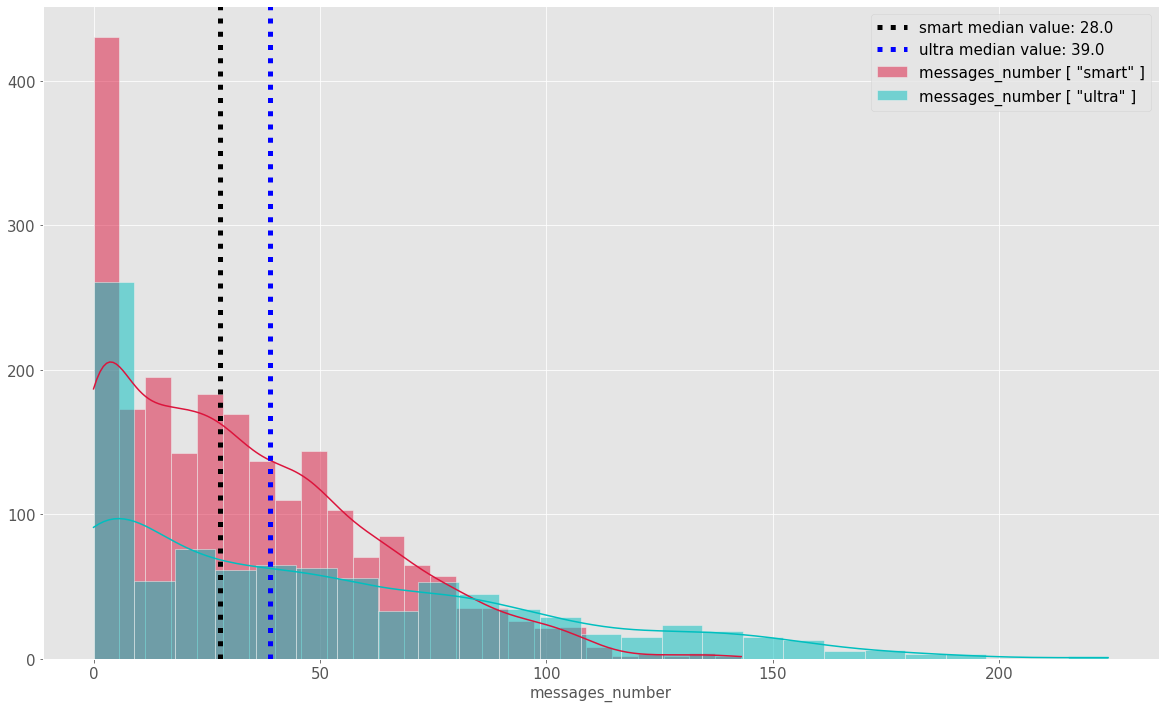

In [63]:
plot_hists(resulting_df, _c_t = 'messages_number', _func = 'median', _bins=25)

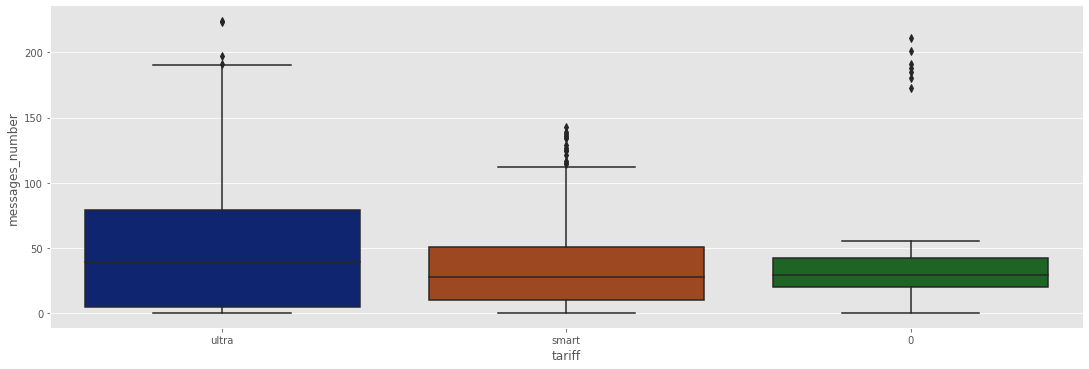

In [64]:
plot_catplot(resulting_df, 'tariff', 'messages_number', _height = 5, _aspect = 3)

In [65]:
print("Влючено сообщений в тарифы 'smart' и 'ultra' ")
display(df_tariffs[['tariff', 'messages_included']])
print("")
print("Фактически сообщений в тарифе 'smart'")
get_box_and_whisker_info(resulting_df.query('tariff == "smart"')['messages_number'])
print("")
print("Фактически сообщений в тарифе  'ultra'")
get_box_and_whisker_info(resulting_df.query('tariff == "ultra"')['messages_number'])

Влючено сообщений в тарифы 'smart' и 'ultra' 


,tariff,messages_included
0,smart,50
1,ultra,1000



Фактически сообщений в тарифе 'smart'
'Q1 == 10.00, Q3 == 51.00, IQR == 41.00'
'[Q1 - 1.5*IQR] == -51.50, [Q3 + 1.5*IQR] == 112.50'

Фактически сообщений в тарифе  'ultra'
'Q1 == 5.00, Q3 == 79.00, IQR == 74.00'
'[Q1 - 1.5*IQR] == -106.00, [Q3 + 1.5*IQR] == 190.00'


Тариф `smart` <br>
Средний пользователь данного тарифа отправляет около 30 смс-сообщений в месяц.<br>
Основная масса пользователей тарифа `smart` использует от 10 до 50 сообщений в месяц, но есть и пользователи (также ~25% от общего числа), которые выходят за рамки лимита сообщений включенного в абонентскую плату за тариф (50 сообщений/месяц).

Тариф `ultra` <br>
Средний пользователь данного тарифа отправляет около 50 смс-сообщений в месяц.<br>
Пользователи тарифа `ultra` используют в основном от 5 до 80 сообщений в месяц, но никто из пользователей не превышает лимит сообщений включенный в абонентскую плату за тариф (1000 сообщения/месяц).<br>

В целом абоненты тарифа `smart` пользуются смс-сообщениями меньше, чем абоненты тарифа `ultra`. 
На гистрограммах видно, что в тарифе `ultra` есть пользователи отправляющие в месяц более 100 сообщений, в тарифе `smart` таких абонентов практически нет.

----------------
### Объем интернет-трафика пользователей тарифов
**Среднее, медиана, дисперсия и стандартное отклонение для количества использованных мегабайт пользователями двух тарифов**

In [66]:
internet_resulting_df = resulting_df.pivot_table(index=['tariff'],
                           values='gb_used',
                           aggfunc=['median','mean', np.std, np.var]).reset_index().round()

internet_resulting_df.columns = ['tariff','gb_median', 'gb_mean', 'gb_std', 'gb_var']
internet_resulting_df

,tariff,gb_median,gb_mean,gb_std,gb_var
0,0,18.0,19.0,8.0,70.0
1,smart,17.0,16.0,6.0,33.0
2,ultra,19.0,19.0,10.0,98.0


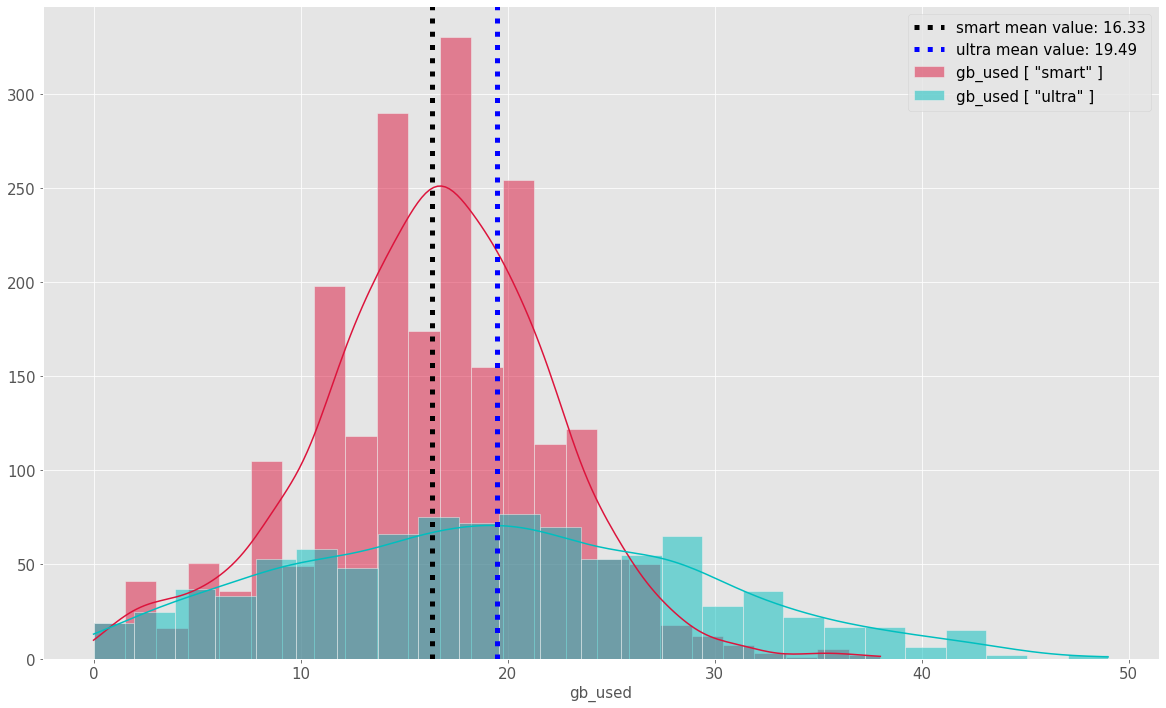

In [67]:
plot_hists(resulting_df, _c_t = 'gb_used', _func = 'mean',_bins=25)

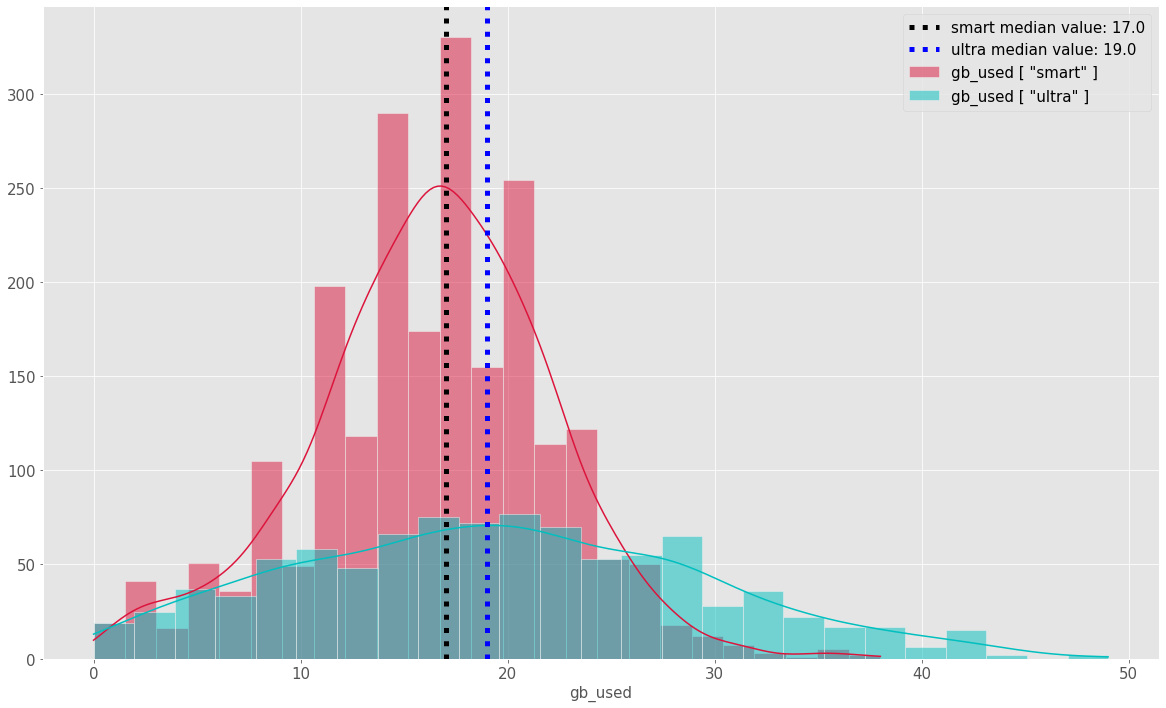

In [68]:
plot_hists(resulting_df, _c_t = 'gb_used', _func = 'median',_bins=25)

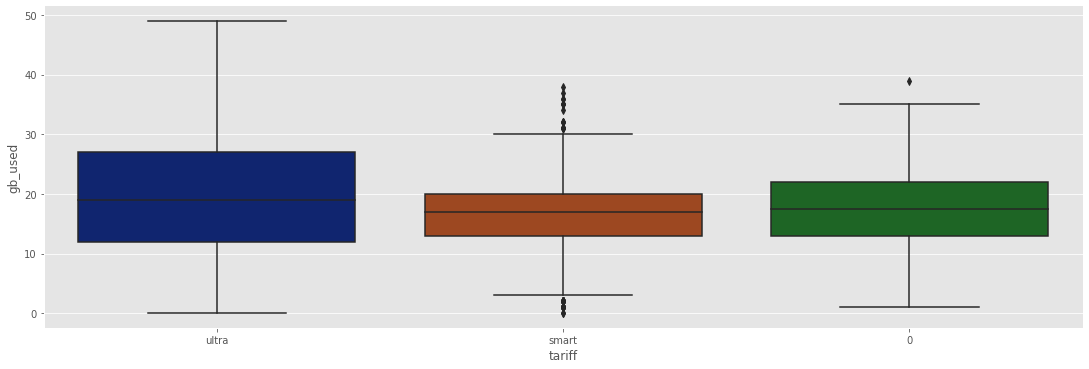

In [69]:
plot_catplot(resulting_df, 'tariff', 'gb_used', _height = 5, _aspect = 3)

In [70]:
print("Включено Мб в тарифы 'smart' и 'ultra' ")
display(df_tariffs[['tariff', 'mb_per_month_included']])
print("")
print("Фактически Мб в тарифе  'smart'")
get_box_and_whisker_info(resulting_df.query('tariff == "smart"')['gb_used'])
print("")
print("Фактически Мб в тарифе  'ultra'")
get_box_and_whisker_info(resulting_df.query('tariff == "ultra"')['gb_used'])

Включено Мб в тарифы 'smart' и 'ultra' 


,tariff,mb_per_month_included
0,smart,15360
1,ultra,30720



Фактически Мб в тарифе  'smart'
'Q1 == 13.00, Q3 == 20.00, IQR == 7.00'
'[Q1 - 1.5*IQR] == 2.50, [Q3 + 1.5*IQR] == 30.50'

Фактически Мб в тарифе  'ultra'
'Q1 == 12.00, Q3 == 27.00, IQR == 15.00'
'[Q1 - 1.5*IQR] == -10.50, [Q3 + 1.5*IQR] == 49.50'


Тариф `smart` <br>
Средний пользователь данного тарифа использует в месяц около 16 Гб. <br>
Основная масса пользователей тарифа smart использует от 13 до 20 Гб в месяц, больше половины пользователей доплачивают за трафик сверх лимита (15 Гб/месяц).

Тариф `ultra` <br>
Средний пользователь данного тарифа использует в месяц около 20 Гб. <br>
Пользователи тарифа `ultra` используют в основном от 12 до 27 Гб в месяц, но есть и пользователи, которые покупают дополнительный объем интернета сверх лимита (30 Гб/месяц). <br>

В целом абоненты тарифа `smart` пользуются интернетом меньше, чем абоненты тарифа `ultra`. 

In [71]:
revenue_result_df = resulting_df.pivot_table(index=['tariff'],
                           values='user_revenue',
                           aggfunc=['median','mean', np.var, np.std, sum]).reset_index().round()

revenue_result_df.columns = ['revenue','rv_median', 'rv_mean', 'rv_var', 'rv_std','sum']
revenue_result_df

,revenue,rv_median,rv_mean,rv_var,rv_std,sum
0,0,0.0,0.0,0.0,0.0,0.0
1,smart,1030.0,1291.0,670957.0,819.0,2869651.0
2,ultra,1950.0,2071.0,143962.0,379.0,1969500.0


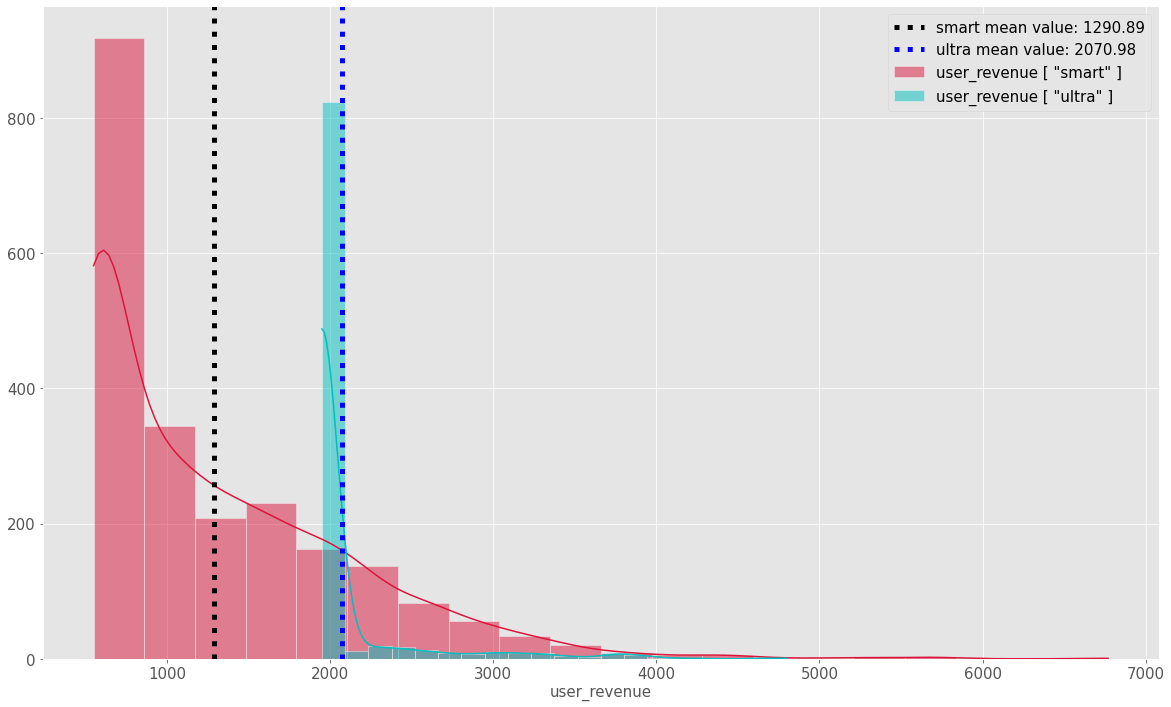

In [72]:
plot_hists(resulting_df, _c_t = 'user_revenue', _func = 'mean',_bins=20)

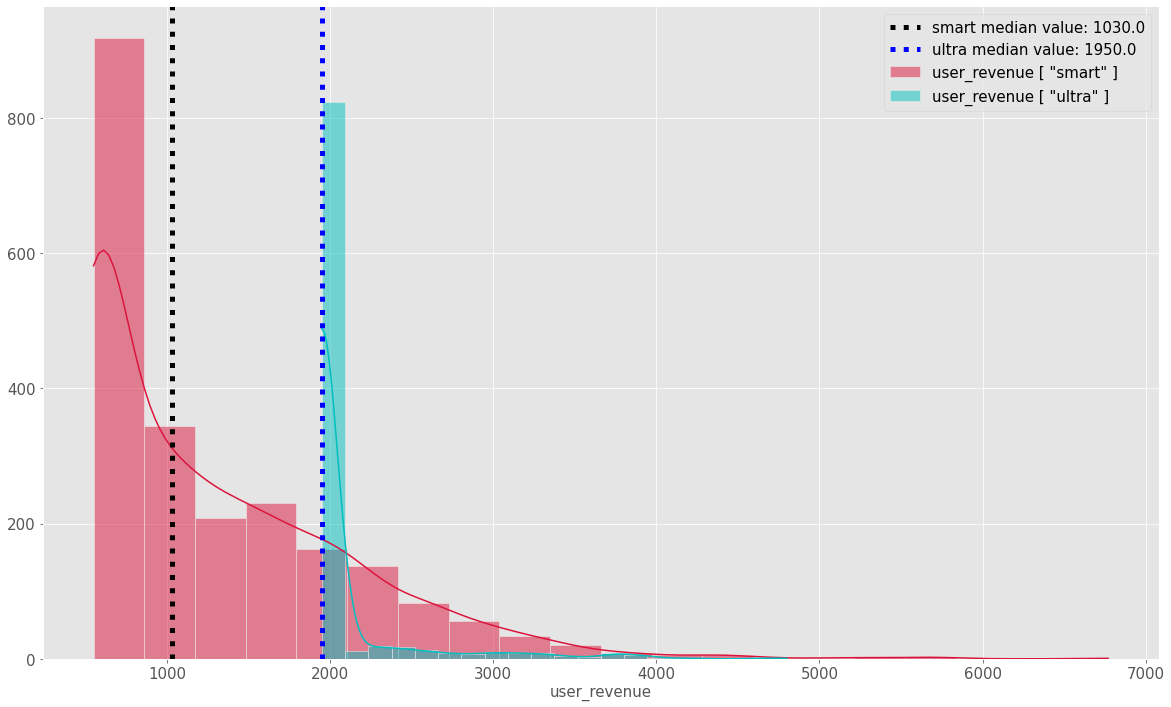

In [73]:
plot_hists(resulting_df, _c_t = 'user_revenue', _func = 'median',_bins=20)

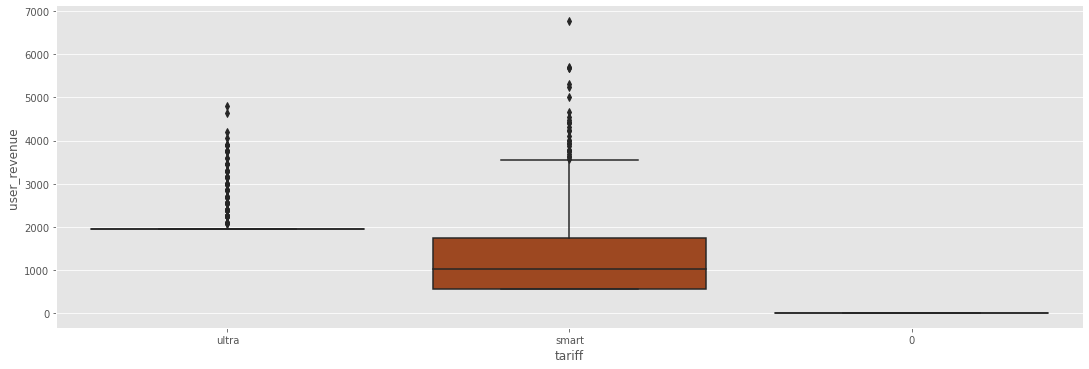

In [74]:
plot_catplot(resulting_df, 'tariff', 'user_revenue', _height = 5, _aspect = 3)

In [75]:
print("Абонентская плата тарифы 'smart' и 'ultra' ")
display(df_tariffs[['tariff', 'rub_monthly_fee']])
print("")
print("Выручка в тарифе  'smart'")
get_box_and_whisker_info(resulting_df.query('tariff == "smart"')['user_revenue'])
print("")
print("Выручка в тарифе  'ultra'")
get_box_and_whisker_info(resulting_df.query('tariff == "ultra"')['user_revenue'])

Абонентская плата тарифы 'smart' и 'ultra' 


,tariff,rub_monthly_fee
0,smart,550
1,ultra,1950



Выручка в тарифе  'smart'
'Q1 == 550.00, Q3 == 1750.00, IQR == 1200.00'
'[Q1 - 1.5*IQR] == -1250.00, [Q3 + 1.5*IQR] == 3550.00'

Выручка в тарифе  'ultra'
'Q1 == 1950.00, Q3 == 1950.00, IQR == 0.00'
'[Q1 - 1.5*IQR] == 1950.00, [Q3 + 1.5*IQR] == 1950.00'


Большую часть выручки приносят пользователи тарифа `smart`, потому что их количество составляет 70% от всех абонентов в выборке. Но средняя выручка выше у тарифа `ultra` = 2 071 руб/мес, тогда как один абонент `smart` в среднем приносит 1 291 руб/мес. 



## Проверка гипотез


### Средние значения выручки для пользователей тарифов "Ultra" и "Smart" различаются

 Формулируем нулевую и альтернативную гипотезы:
 - $H_0$ -- средние значения выручки для пользователей тарифов "Ultra" и "Smart" равны между собой;
 - $H_1$ -- средние значения выручки для пользователей тарифов "Ultra" и "Smart" отличаются друг от друга.
 
Критический уровень статистической значимости 5% ($\alpha = 0.05$)

Так как выборки у нас независимые - воспользуемся функцией ttest_ind

In [76]:
ALPHA_CONST_VALUE = float(.05)

p_value = st.ttest_ind(resulting_df.loc[ resulting_df['tariff'] == 'smart', 'user_revenue'],
                       resulting_df.loc[ resulting_df['tariff'] == 'ultra', 'user_revenue'], 
                       equal_var = False).pvalue

print(" ")
if p_value < ALPHA_CONST_VALUE:
    print("p_value < ALPHA_CONST_VALUE ==> нулевая гипотеза отвергается.")
else:
    print("p_value > ALPHA_CONST_VALUE ==> нулевая гипотеза не может быть отвергнута.")

print(" ")
print("p_value = {}, alpha = {}.".format(p_value, ALPHA_CONST_VALUE))

average_revenue_smart = round(resulting_df.loc[ resulting_df['tariff'] == 'smart', 'user_revenue'].mean(), 0)
average_revenue_ultra = round(resulting_df.loc[ resulting_df['tariff'] == 'ultra', 'user_revenue'].mean(), 0)
print(" ")
print("Среднее значение выручки для пользователей Smart: {}".format(average_revenue_smart))
print("Среднее значение выручки для пользователей Utra: {}".format(average_revenue_ultra))


 
p_value < ALPHA_CONST_VALUE ==> нулевая гипотеза отвергается.
 
p_value = 3.155173205867294e-245, alpha = 0.05.
 
Среднее значение выручки для пользователей Smart: 1291.0
Среднее значение выручки для пользователей Utra: 2071.0


In [77]:
revenue_result_df

,revenue,rv_median,rv_mean,rv_var,rv_std,sum
0,0,0.0,0.0,0.0,0.0,0.0
1,smart,1030.0,1291.0,670957.0,819.0,2869651.0
2,ultra,1950.0,2071.0,143962.0,379.0,1969500.0


Нулевая гипотеза отвергнута - средние значения выручки абонентов тарифов "Ultra" и "Smart" не равны, что еще раз подтвердило наш вывод из п.3.


### Средние значения выручки для пользователей г. Москва  и пользователей других регионов различаются

 Формулируем нулевую и альтернативную гипотезы:
 - $H_0$ -- средние значения выручки для пользователей г. Москва  и пользователей других регионов равны между собой;
 - $H_1$ -- средние значения выручки для пользователей г. Москва  и пользователей других регионов отличаются друг от друга.
 
Критический уровень статистической значимости 5% ($\alpha = 0.05$)

Так как выборки независимые - воспользуемся функцией ttest_ind

In [78]:
ALPHA_CONST_VALUE = float(.05)

p_value = st.ttest_ind(resulting_df.loc[ resulting_df['city'] == 'Москва', 'user_revenue'],
                       resulting_df.loc[ resulting_df['city'] != 'Москва', 'user_revenue'], 
                       equal_var = False).pvalue

print(" ")
if p_value < ALPHA_CONST_VALUE:
    print("p_value < ALPHA_CONST_VALUE ==> нулевая гипотеза отвергается.")
else:
    print("p_value > ALPHA_CONST_VALUE ==> нулевая гипотеза не может быть отвергнута.")

print(" ")
print("p_value = {}, alpha = {}.".format(p_value, ALPHA_CONST_VALUE))

average_revenue_smart = round(resulting_df.loc[ resulting_df['city'] == 'Москва', 'user_revenue'].mean(), 0)
average_revenue_ultra= round(resulting_df.loc[ resulting_df['city'] != 'Москва', 'user_revenue'].mean(), 0)
print(" ")
print("Среднее значение выручки для пользователей г. Москва: {}".format(average_revenue_smart))
print("Среднее значение выручки для пользователей других регионов: {}".format(average_revenue_ultra))

 
p_value > ALPHA_CONST_VALUE ==> нулевая гипотеза не может быть отвергнута.
 
p_value = 0.1487216666465577, alpha = 0.05.
 
Среднее значение выручки для пользователей г. Москва: 1546.0
Среднее значение выручки для пользователей других регионов: 1496.0


In [79]:
msk_revenue_result_df = resulting_df.query('city == "Москва"')
other_revenue_result_df = resulting_df.query('city != "Москва"')
other_revenue_result_df['city'] = 'other' 
msk_revenue_result_df = msk_revenue_result_df.pivot_table(index=['city'],
                           values='user_revenue',
                           aggfunc=['median','mean', np.var, np.std, sum]).reset_index().round()
msk_revenue_result_df.columns = ['revenue','rv_median', 'rv_mean', 'rv_var', 'rv_std','sum']
other_revenue_result_df = other_revenue_result_df.pivot_table(index=['city'],
                           values='user_revenue',
                           aggfunc=['median','mean', np.var, np.std, sum]).reset_index().round()
other_revenue_result_df.columns = ['revenue','rv_median', 'rv_mean', 'rv_var', 'rv_std','sum']
display(msk_revenue_result_df)
display(other_revenue_result_df)

,revenue,rv_median,rv_mean,rv_var,rv_std,sum
0,Москва,1750.0,1546.0,566298.0,753.0,943092.0


,revenue,rv_median,rv_mean,rv_var,rv_std,sum
0,other,1550.0,1496.0,683315.0,827.0,3896059.0


Проведенный анализ говорит о том, что в среднем выручка полученная от пользователя из Москвы примерно соответствует выручке полученной от абонента из другого региона.

## Выводы

Пользователи тарифа `smart` используют меньшее количество минут звонков и сообщений в месяц, чем пользователи `ultra`.
Практически 25% абонентов `smart` переплачивают за услуги голосовой связи и смс-сообщений сверх лимита установленного в данном тарифе, интернет же докупают более половины пользователей.
В тарифе `ultra` лимита на звонки и минуты не достигает никто, но некоторое количество пользователей покупает дополнительные пакеты интернет-трафика.<br>

Что же касается выручки, то б*О*льшую ее часть приносят пользователи тарифа `smart`, так как их количество составляет 70%. Но средняя выручка (или же выручка на пользователя) выше у тарифа `ultra` и составляет 2 071 руб/мес, в то время как один абонент `smart` в среднем приносит компании 1 291 руб/мес. Причем не обнаружена зависимость суммы средней выручки получаемой сотовым оператором с одного пользователя в месяц от региона его проживания (Москва и прочие регионы).

Таким образом, можно сделать вывод, что для сотового оператора выгоднее подключать/переводить абонентов на тариф `ultra`.

Если же говорить о том, какой тариф предпочтительнее для пользователя, то здесь необходимо исходить из его индивидуальных потребностей. 
В том случае, если существует необходимость использования услуг сотовой связи в объемах существенно превышающих лимиты включенные в тариф `smart`, то можно рассмотреть вариант приобретения тарифного плана `ultra`. 
